In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, roc_curve, auc
from imblearn.pipeline import Pipeline
# Estimator
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# for SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import utilitaires_810 as u810


TEST_SIZE = 0.2
RANDOM_STATE = 42
GIT_FOLDER = './'
DOSSIER_IMG = GIT_FOLDER+'temp_img/'

# ---------------------------------------------------------------- MAKE SCRORER
def custom_metric(y_true, y_pred) :
    faux_negs = np.sum((y_true == 1) & (y_pred == 0))
    faux_pos = np.sum((y_true == 0) & (y_pred == 1))
    true_pos = np.sum((y_true == 1) & (y_pred == 1))
    # true_negs = np.sum((y_true == 0) & (y_pred == 0))
    f2_score = true_pos/(true_pos + 0.2 * faux_pos + 0.8 * faux_negs)
    return f2_score

custom_score = make_scorer(custom_metric, greater_is_better=True)

# TRAITEMENT NAN DATA ENTRAINEMENT

TODO :
Put it in utilitaires_810
- Get Resultification_function
- Reduce DataFrame size
- OneHotEncode Values

PRINT Resultification for GridSearchRunning
ENLEVER LES EXT_SOURCE > ENTRAINER UN MODEL > RECUPERER LES 50 FEATURES LES PLUS IMPORTANTES

In [2]:
train_df = pd.read_csv('./input_data/application_train.csv')

In [3]:
train_df.loc[:, 'taux_nan'] = train_df.isna().sum(axis=1)/(train_df.shape[1]-1)

In [4]:
train_df['taux_nan'].describe()

count    307511.000000
mean          0.245976
std           0.172887
min           0.000000
25%           0.041322
50%           0.297521
75%           0.404959
max           0.504132
Name: taux_nan, dtype: float64

In [5]:
lignes_pleines = train_df[train_df['taux_nan'] < 0.30]
lignes_pleines.shape[0]/train_df.shape[0]

0.5001251987733772

In [6]:
lignes_pleines.isna().sum()[lignes_pleines.isna().sum()!=0]

AMT_ANNUITY                        6
AMT_GOODS_PRICE                  128
NAME_TYPE_SUITE                  690
OWN_CAR_AGE                   103675
OCCUPATION_TYPE                48092
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY      18667
AMT_REQ_CREDIT_BUREAU_WEEK     18667
AMT_REQ_CREDIT_BUREAU_MON      18667
AMT_REQ_CREDIT_BUREAU_QRT      18667
AMT_REQ_CREDIT_BUREAU_YEAR     18667
Length: 66, dtype: int64

In [7]:
DEFAULT_MAX_PERCENTAGE_NAN_VAL = 30

def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

def remove_too_nany_columns(df, treshold=DEFAULT_MAX_PERCENTAGE_NAN_VAL):
    """
    Supprime les colonnes dont la part de NaN est superieure a un certains pourcentage
    :param df:
    :param treshold: En pourcentage
    :return:
    """
    print("Forme avant traitement : ", df.shape)
    missing_values = missing_values_table(df=df)
    not_too_nany_cols = [col for col in df.columns if
                         col not in missing_values[
                             missing_values['% of Total Values'] > treshold].index.tolist()]
    print(
        f"Suppression des {df.shape[1] - len(not_too_nany_cols)} colonnes avec plus de {treshold}% de valeurs manquantes")
    df_moderate_bias = df[not_too_nany_cols]
    print(f"Dataset sans les features vides a plus de {treshold}% : ", df_moderate_bias.shape)
    return df_moderate_bias

In [8]:
dfmv = missing_values_table(lignes_pleines).reset_index()

In [9]:
dfmv[dfmv['% of Total Values'] > 30]

,index,Missing Values,% of Total Values
0,OWN_CAR_AGE,103675,67.4
1,EXT_SOURCE_1,83458,54.3
2,COMMONAREA_AVG,61150,39.8
3,COMMONAREA_MODE,61150,39.8
4,COMMONAREA_MEDI,61150,39.8
5,NONLIVINGAPARTMENTS_MEDI,59797,38.9
6,NONLIVINGAPARTMENTS_MODE,59797,38.9
7,NONLIVINGAPARTMENTS_AVG,59797,38.9
8,FONDKAPREMONT_MODE,56599,36.8
9,LIVINGAPARTMENTS_AVG,56486,36.7


In [10]:
not_toonany_df = remove_too_nany_columns(lignes_pleines)
print("Forme finale : ", not_toonany_df.shape)

Forme avant traitement :  (153794, 123)
Suppression des 19 colonnes avec plus de 30% de valeurs manquantes
Dataset sans les features vides a plus de 30% :  (153794, 104)
Forme finale :  (153794, 104)


In [11]:
features_selected = not_toonany_df.columns.tolist()

In [12]:
not_toonany_df['TARGET'].value_counts(normalize=True)

0    0.930517
1    0.069483
Name: TARGET, dtype: float64

# ETUDE NAN DATA PROD (TEST)

In [13]:
test_df = pd.read_csv('./input_data/application_test.csv')

In [14]:
test_df.loc[:, 'taux_nan'] = test_df.isna().sum(axis=1)/(test_df.shape[1]-1)
test_df['taux_nan'].describe()

count    48744.000000
mean         0.240101
std          0.174468
min          0.000000
25%          0.033333
50%          0.250000
75%          0.400000
max          0.508333
Name: taux_nan, dtype: float64

In [15]:
test_lignes_pleines = test_df[test_df['taux_nan'] < 0.30]
test_lignes_pleines.shape[0]/test_df.shape[0]

0.5175406203840472

In [16]:
dfmv_tst = missing_values_table(test_lignes_pleines).reset_index()
dfmv_tst[dfmv_tst['% of Total Values'] > 30]

,index,Missing Values,% of Total Values
0,OWN_CAR_AGE,17134,67.9
1,EXT_SOURCE_1,10353,41.0
2,COMMONAREA_MEDI,9979,39.6
3,COMMONAREA_MODE,9979,39.6
4,COMMONAREA_AVG,9979,39.6
5,NONLIVINGAPARTMENTS_AVG,9830,39.0
6,NONLIVINGAPARTMENTS_MEDI,9830,39.0
7,NONLIVINGAPARTMENTS_MODE,9830,39.0
8,FONDKAPREMONT_MODE,9282,36.8
9,LIVINGAPARTMENTS_MODE,9263,36.7


A priori ce sont toujours les memes colonnes qui sont tres peu renseignees.

La part de dossier incomplet est aussi la meme et est proche de 50%.

# SAVE NEW DS TO CSV

In [17]:
not_toonany_df.to_csv('./processed_data/training_nan_removal.csv')

# TEST APPLYING OC KERNEL

In [20]:
import custom_kernel_RefOC as ckk

df_fe = ckk.full_feature_engineering(df_input=not_toonany_df, df_folder='./input_data/')

/home/maximorose/git_repositories/oc-ds-p07/custom_kernel_RefOC.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[bin_feature], uniques = pd.factorize(df[bin_feature])


Application dataframe shape:  (153794, 161)
application processing - done in 0s
Bureau and bureau_balance processing - done in 12s
Previous dataframe shape:  (338857, 186)
previous_application processing - done in 15s
Pos-cash dataframe shape:  (337252, 12)
Installments dataframe shape:  (339587, 26)
Credit card dataframe shape:  (103558, 121)
previous applications balances processing - done in 33s


In [21]:
df_fe.shape

(153794, 603)

In [24]:
X = df_fe.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = df_fe['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

X_train : (123035, 601) // X_test : (30759, 601)
y_train : (123035,) // y_test : (30759,)


In [25]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = LogisticRegression(class_weight='balanced', max_iter=200, penalty='l2', solver='lbfgs')

In [26]:
model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

/home/maximorose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 LogisticRegression(class_weight='balanced', max_iter=200))])

 TRAIN F2 score model :  0.40587103113180883


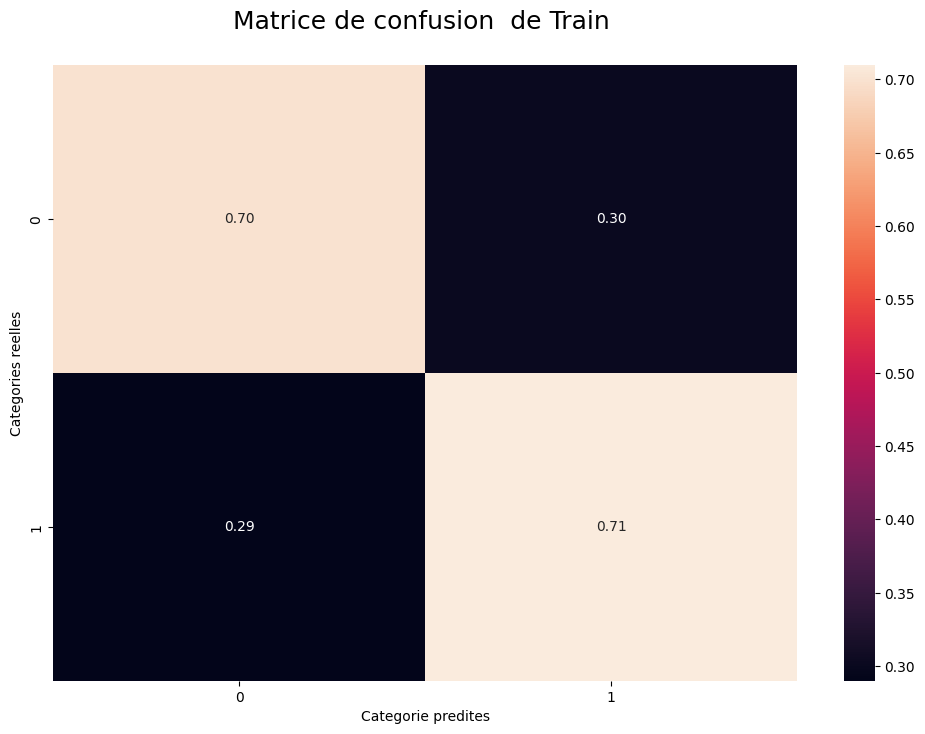

F2 score model 1 :  0.3979762999837671


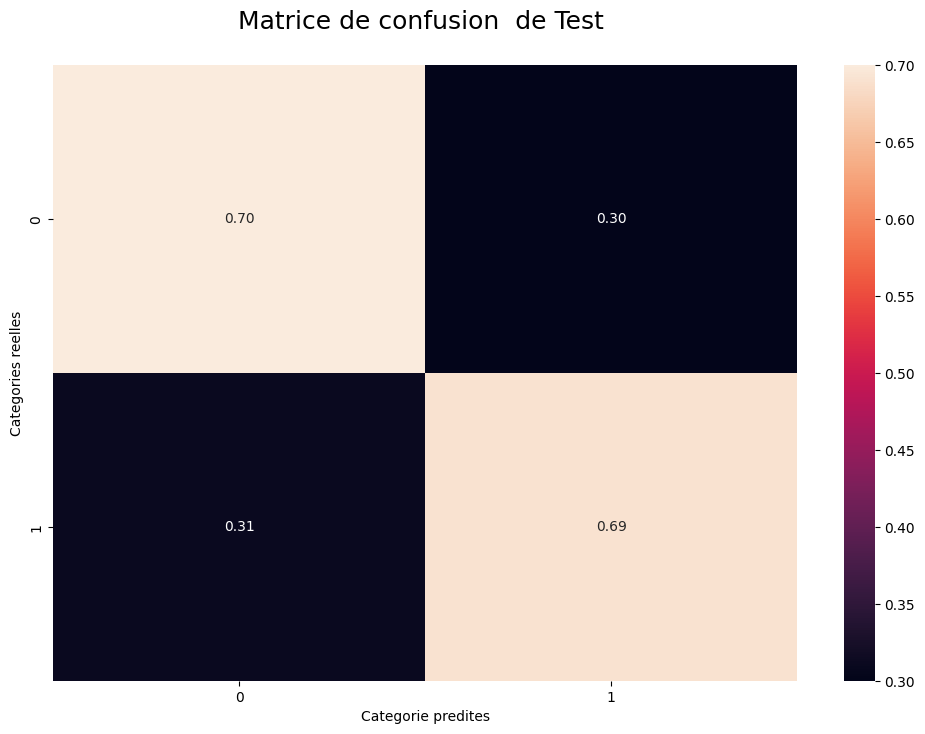

In [29]:
with mlflow.start_run():
    mlflow.log_param("Feature Engineering", "Not embedded in Pipeline")
    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", "Best LogReg")
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [32]:
estimator = RandomForestClassifier()

model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator', RandomForestClassifier())])

 TRAIN F2 score model :  0.9132376191086612


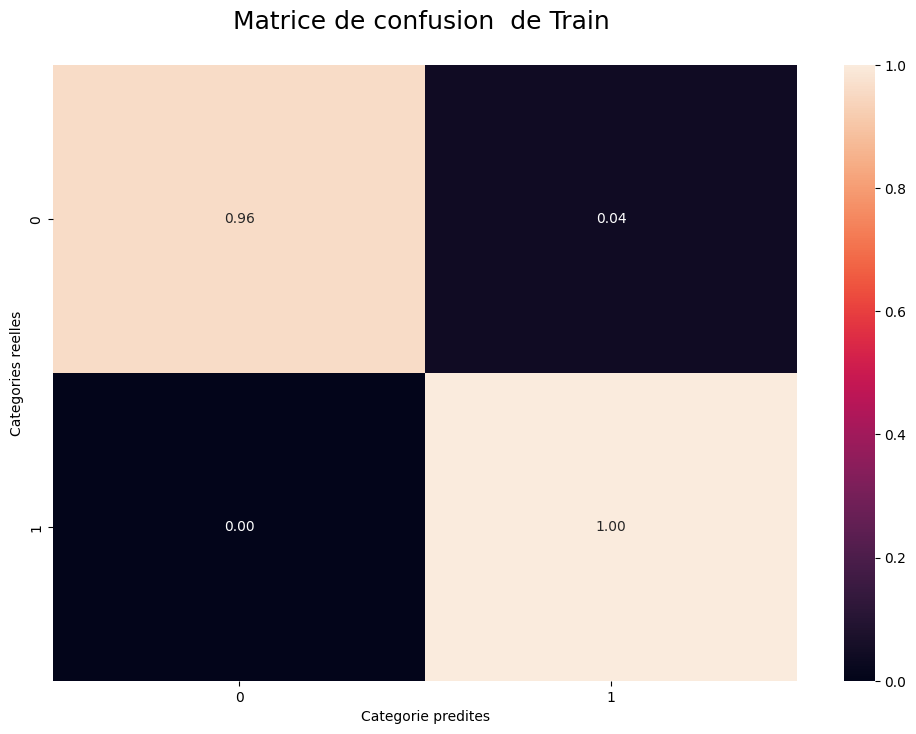

F2 score model 1 :  0.20882237871674492


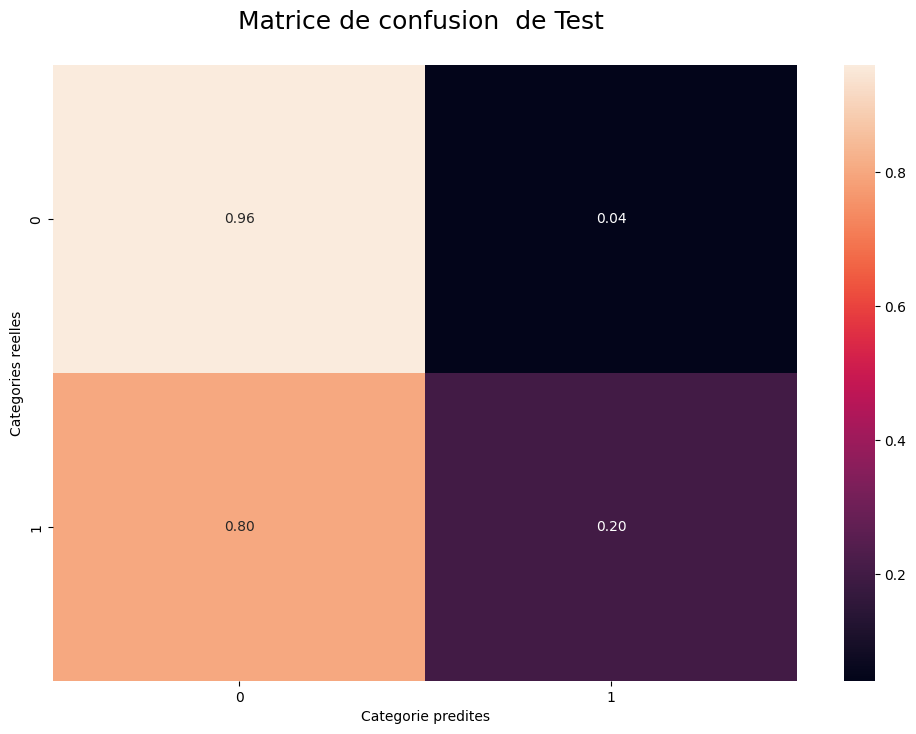

In [33]:
with mlflow.start_run():
    mlflow.log_param("Feature Engineering", "Not embedded in Pipeline")
    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", "Best LogReg")
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

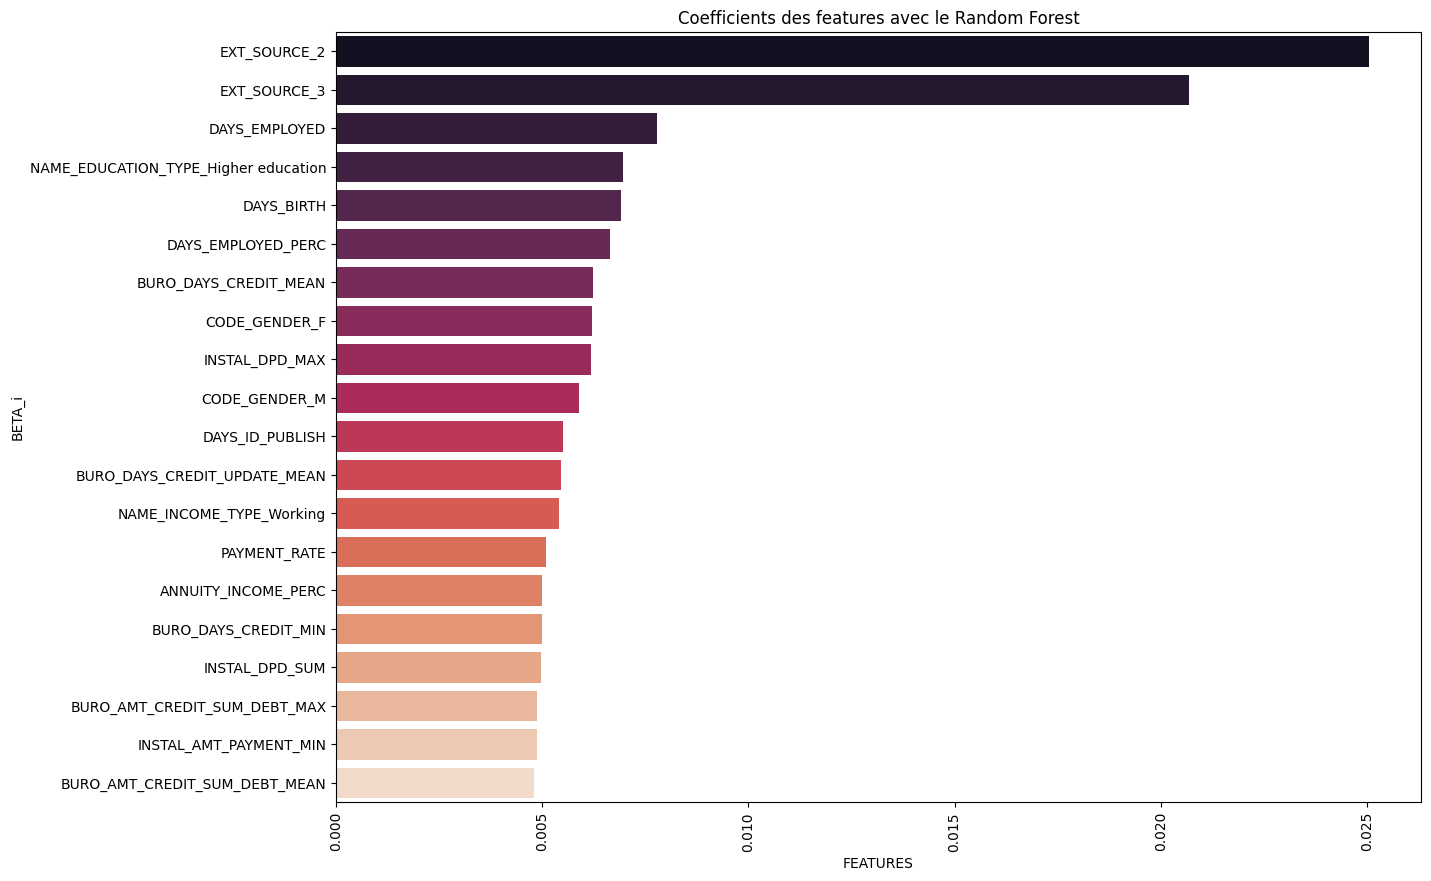

In [34]:
featimps = u810.feature_importance_rf(X_train, model['estimator'])

# Recherche Params Random Forest

In [35]:
estimator = RandomForestClassifier(n_estimators =  200, class_weight='balanced') #


# Parametres Random Forest
params = {
    'estimator__min_samples_split' : [100, 200, 500],
    'estimator__max_depth' : [10, 20, 50]
}

pipeline = Pipeline(
    [
        # ("feature_engineering", feature_engineering_transformer),
        ("imputer", imputer),
        ("scaler", scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_estimators=200))]),
             param_grid={'estimator__max_depth': [10, 20, 50],
                         'estimator__min_samples_split': [100, 200, 500]},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [36]:
model.best_params_

{'estimator__max_depth': 10, 'estimator__min_samples_split': 200}

In [37]:
be = model.best_estimator_
be.fit(X_train, y_train)

 TRAIN F2 score model :  0.4326979818246193


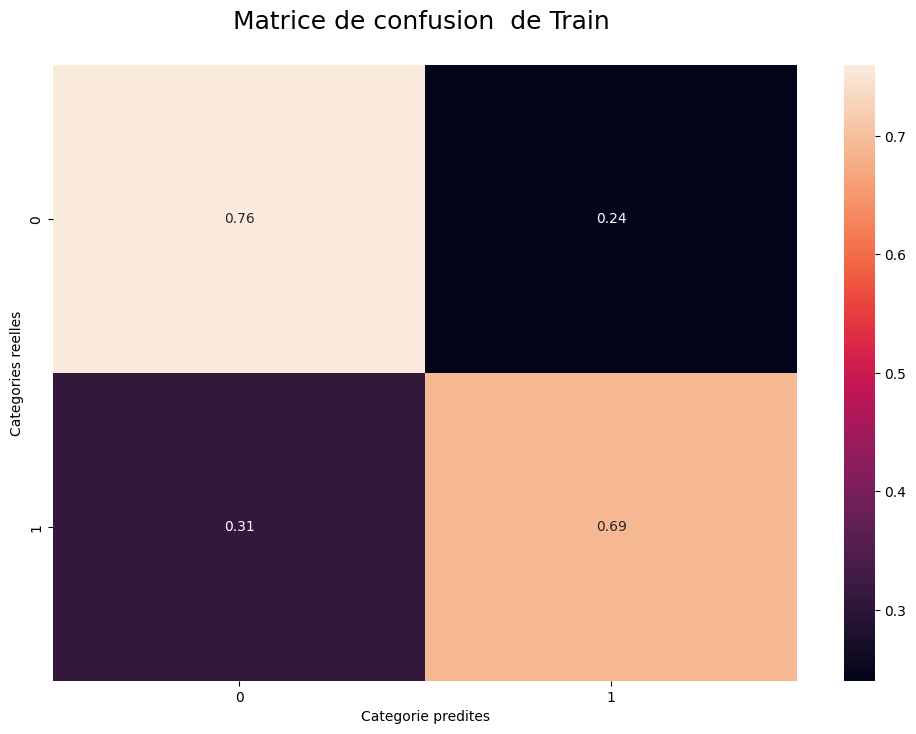

F2 score model 1 :  0.3747779751332149


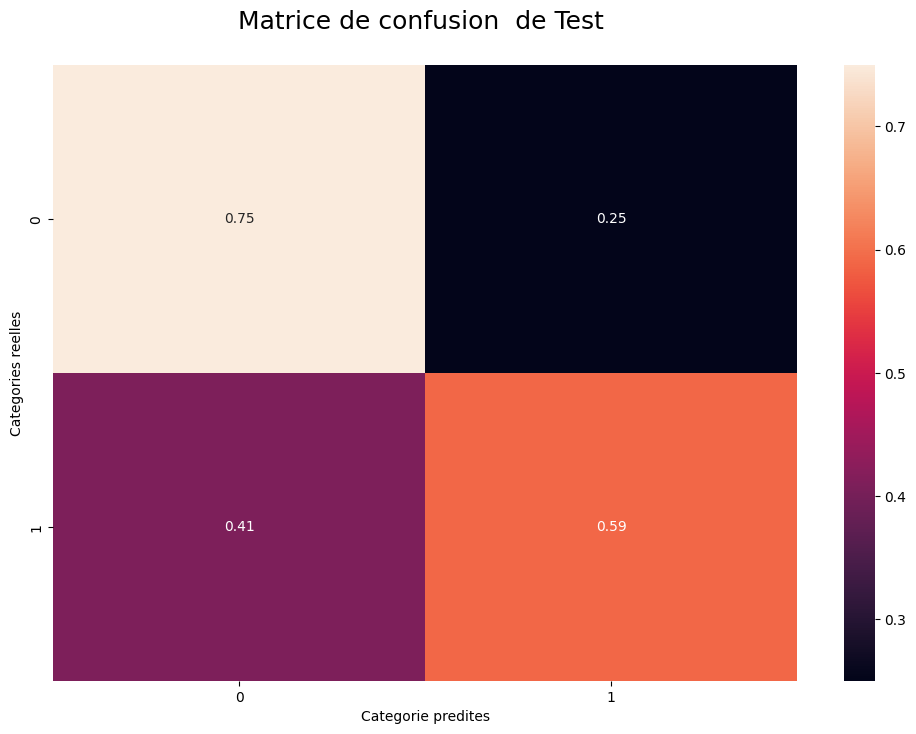

In [38]:
with mlflow.start_run():
    mlflow.log_param("Feature Engineering", "Not embedded in Pipeline")
    mlflow.log_param("imputer", str(be['imputer']))
    mlflow.log_param("scaler", str(be['scaler']))
    mlflow.log_param("estimator", str(be['estimator']))
    mlflow.log_param("over-sampler", str(be['over']))
    mlflow.log_param("under-sampler", str(be['under']))
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [40]:
estimator = RandomForestClassifier(class_weight='balanced', min_samples_split=200) #


# Parametres Random Forest
params = {
    'estimator__n_estimators' : [100, 200, 400],
    'estimator__max_depth' : [5, 10]
}

pipeline = Pipeline(
    [
        # ("feature_engineering", feature_engineering_transformer),
        ("imputer", imputer),
        ("scaler", scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced',
                                                               min_samples_split=200))]),
             param_grid={'estimator__max_depth': [5, 10],
                         'estimator__n_estimators': [100, 200, 400]},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [41]:
model.best_params_

{'estimator__max_depth': 10, 'estimator__n_estimators': 400}

In [43]:
be = model.best_estimator_
be.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=200,
                                        n_estimators=400))])

 TRAIN F2 score model :  0.43453524456923304


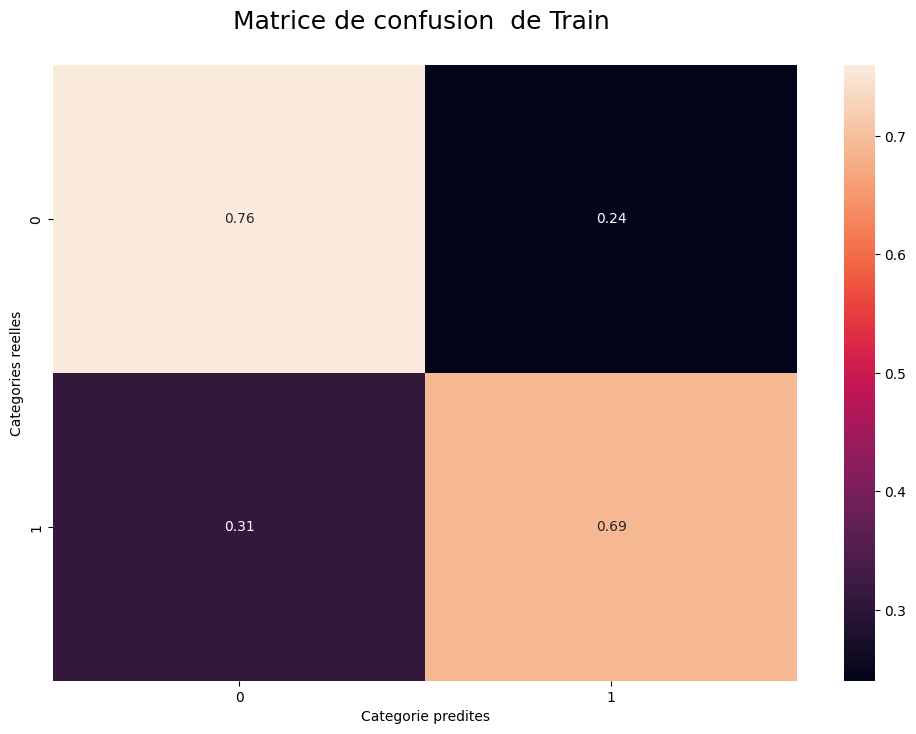

F2 score model 1 :  0.3795477476408095


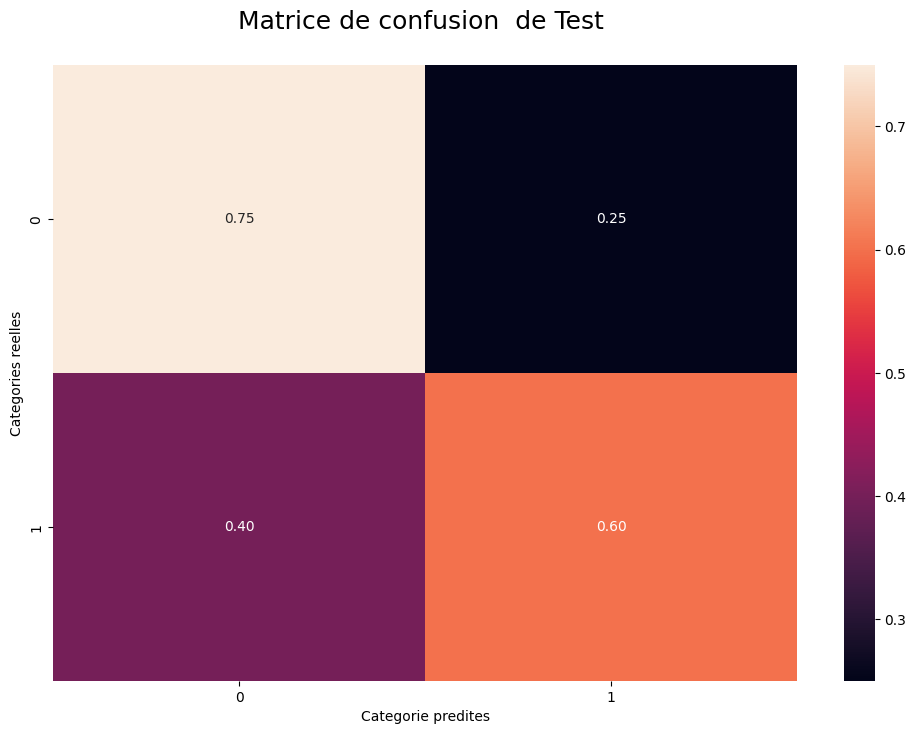

In [44]:
with mlflow.start_run():
    mlflow.log_param("Feature Engineering", "Not embedded in Pipeline")
    mlflow.log_param("imputer", str(be['imputer']))
    mlflow.log_param("scaler", str(be['scaler']))
    mlflow.log_param("estimator", str(be['estimator']))
    mlflow.log_param("over-sampler", str(be['over']))
    mlflow.log_param("under-sampler", str(be['under']))
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

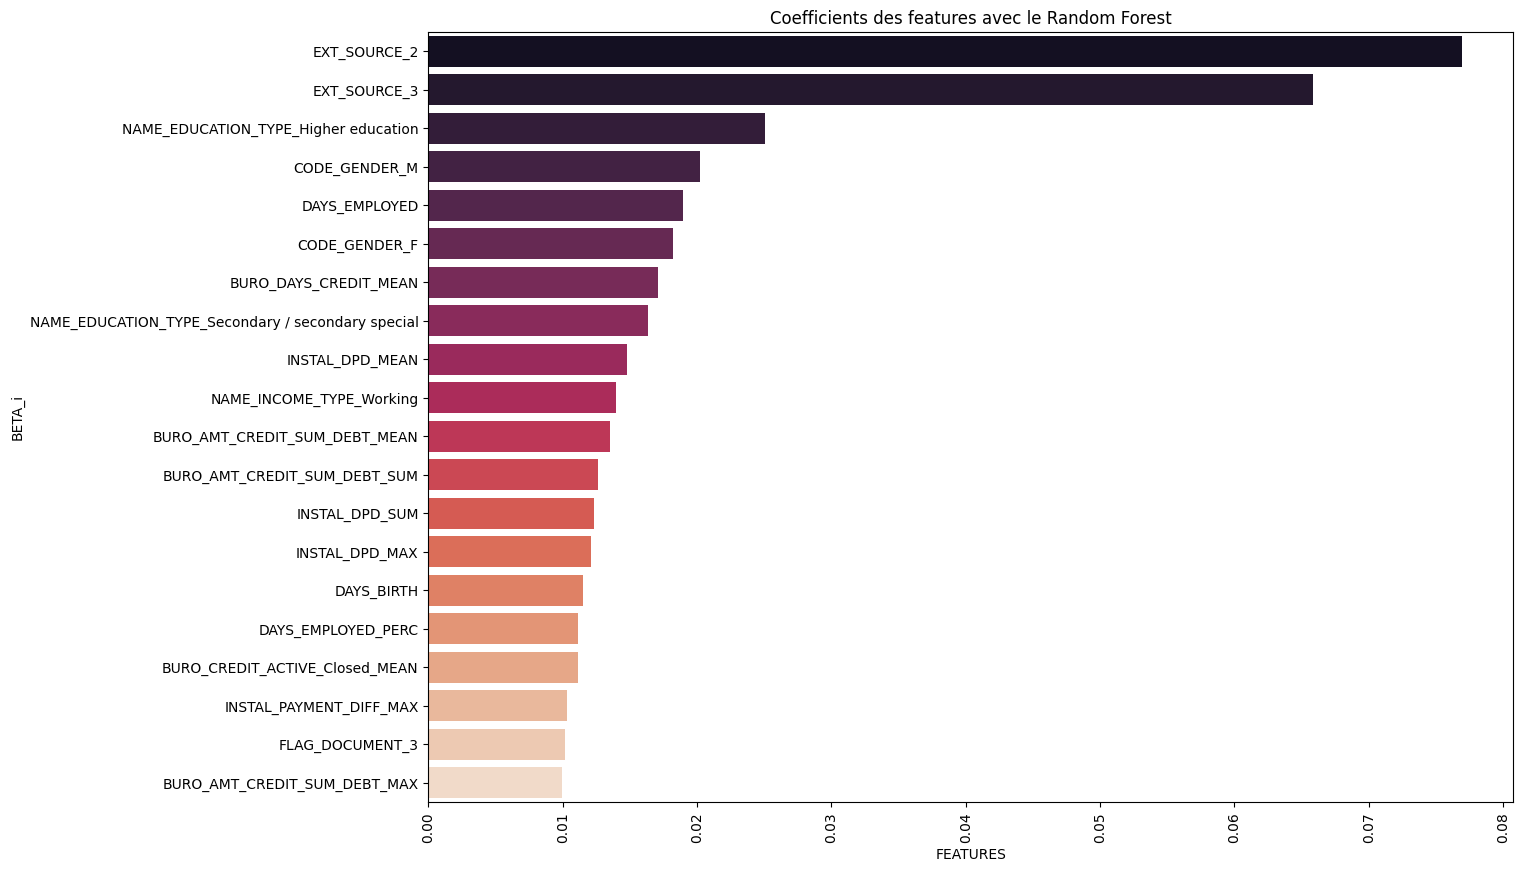

In [45]:
featimps = u810.feature_importance_rf(X_train, be['estimator'])

In [46]:
estimator = RandomForestClassifier(class_weight='balanced', min_samples_split=200, max_depth=10) #


# Parametres Random Forest
params = {
    'estimator__n_estimators' : [400, 600, 800],
}

pipeline = Pipeline(
    [
        # ("feature_engineering", feature_engineering_transformer),
        ("imputer", imputer),
        ("scaler", scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_depth=10,
                                                               min_samples_split=200))]),
             param_grid={'estimator__n_estimators': [400, 600, 800]},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [47]:
model.best_params_

{'estimator__n_estimators': 800}

In [48]:
be = model.best_estimator_
be.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=200,
                                        n_estimators=800))])

 TRAIN F2 score model :  0.4353824814071538


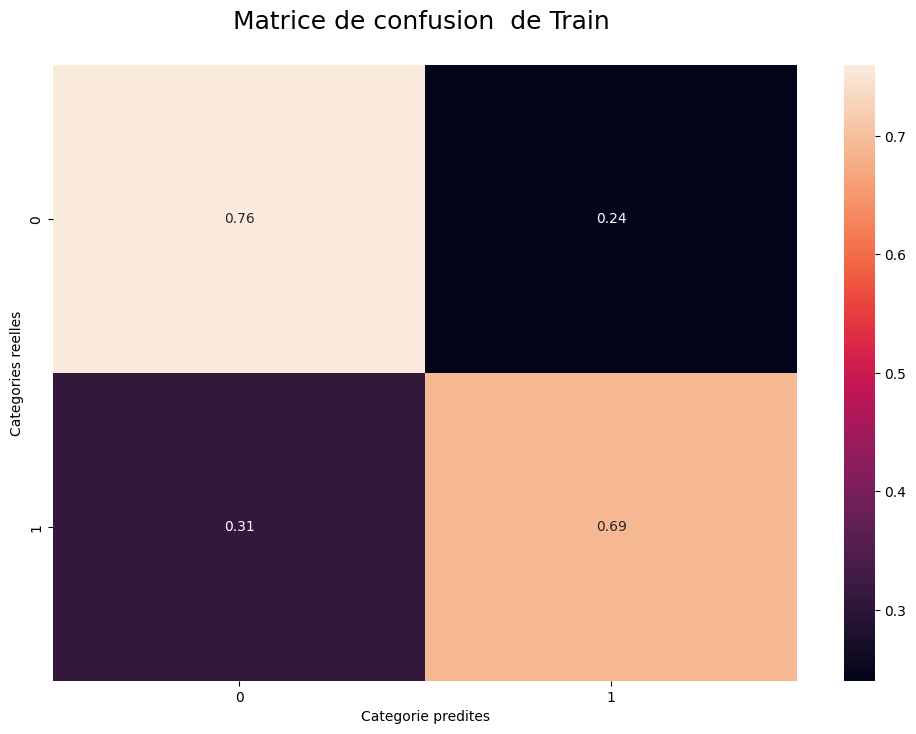

F2 score model 1 :  0.3762962962962963


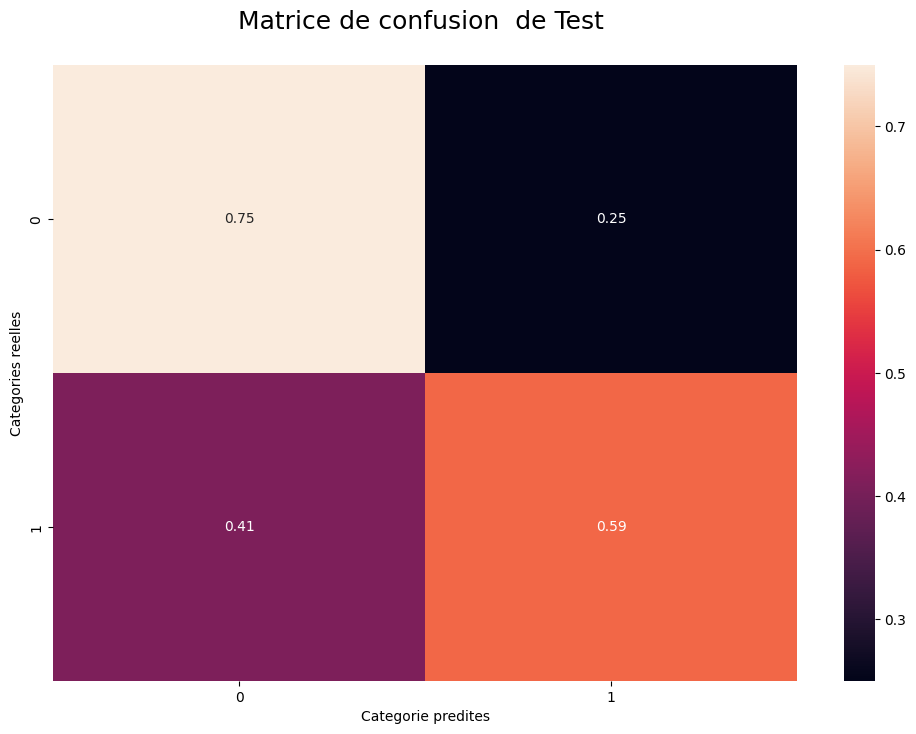

In [49]:
with mlflow.start_run():
    mlflow.log_param("Feature Engineering", "Not embedded in Pipeline")
    mlflow.log_param("imputer", str(be['imputer']))
    mlflow.log_param("scaler", str(be['scaler']))
    mlflow.log_param("estimator", str(be['estimator']))
    mlflow.log_param("over-sampler", str(be['over']))
    mlflow.log_param("under-sampler", str(be['under']))
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

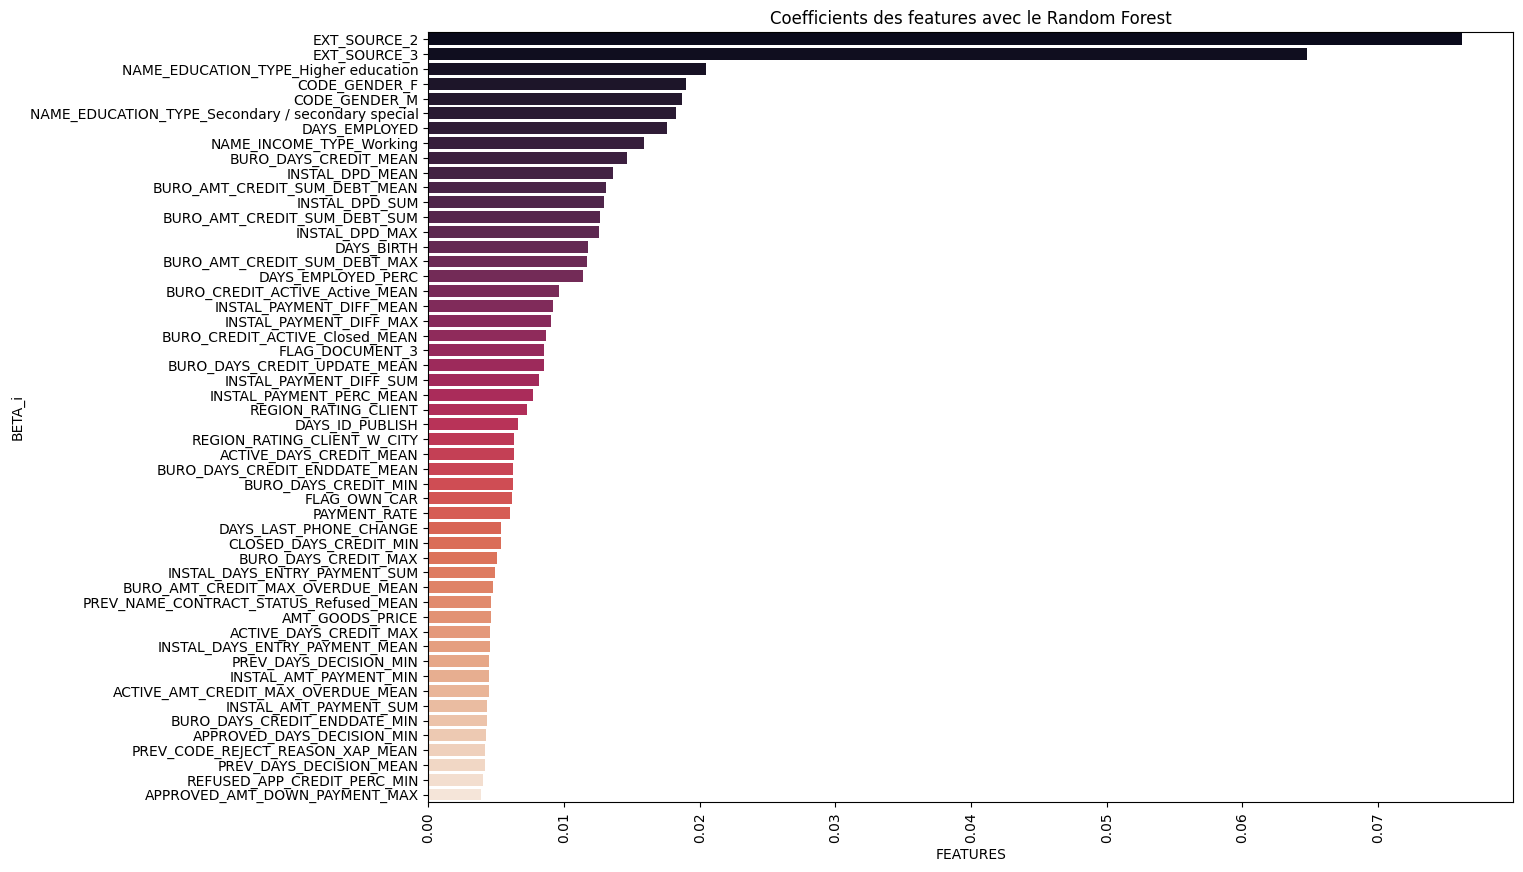

In [52]:
featimps = u810.feature_importance_rf(X_train, be['estimator'], size=52)

In [59]:
X_NoExt = X.drop(columns=['EXT_SOURCE_2', "EXT_SOURCE_3"])
X_NoExt_top50 = X_NoExt[featimps['feature'][2:].tolist()]

X_train, X_test, y_train, y_test = train_test_split(X_NoExt_top50, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

X_train : (123035, 50) // X_test : (30759, 50)
y_train : (123035,) // y_test : (30759,)


In [60]:
estimator = RandomForestClassifier(class_weight='balanced', min_samples_split=200, max_depth=10) #


# Parametres Random Forest
params = {
    'estimator__n_estimators' : [800, 1000, 1500]
}

pipeline = Pipeline(
    [
        # ("feature_engineering", feature_engineering_transformer),
        ("imputer", imputer),
        ("scaler", scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_depth=10,
                                                               min_samples_split=200))]),
             param_grid={'estimator__n_estimators': [800, 1000, 1500]},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [61]:
model.best_params_

{'estimator__n_estimators': 1500}

In [62]:
be = model.best_estimator_
be.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=200,
                                        n_estimators=1500))])

 TRAIN F2 score model :  0.3874440924971791


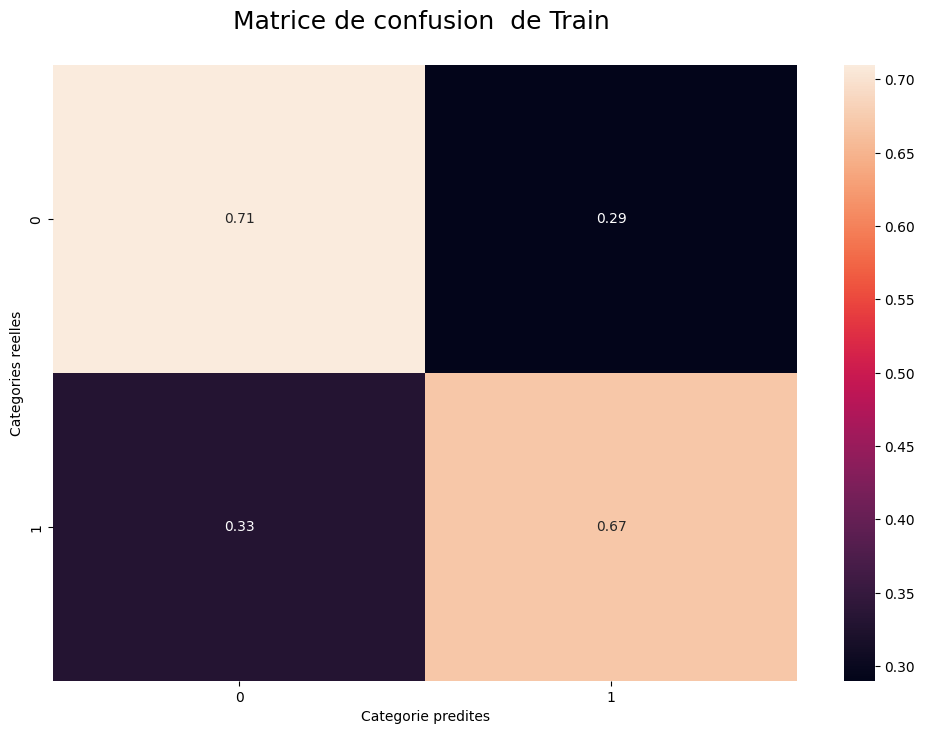

F2 score model 1 :  0.349768455461727


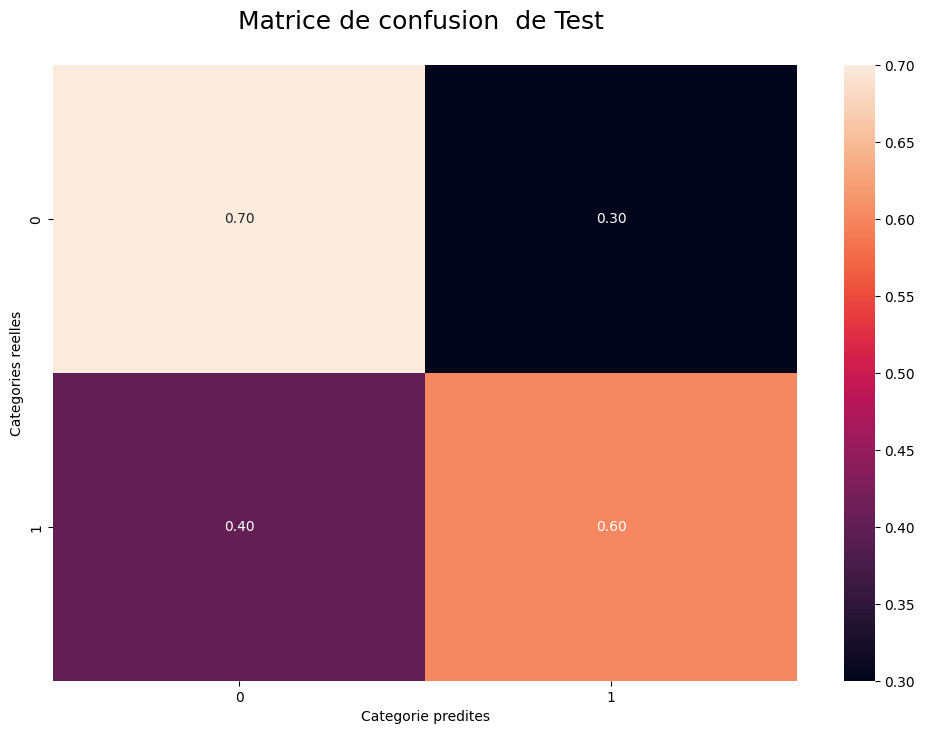

In [63]:
with mlflow.start_run():
    mlflow.log_param("Feature Engineering", "Not embedded in Pipeline")
    mlflow.log_param("imputer", str(be['imputer']))
    mlflow.log_param("scaler", str(be['scaler']))
    mlflow.log_param("estimator", str(be['estimator']))
    mlflow.log_param("over-sampler", str(be['over']))
    mlflow.log_param("under-sampler", str(be['under']))
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

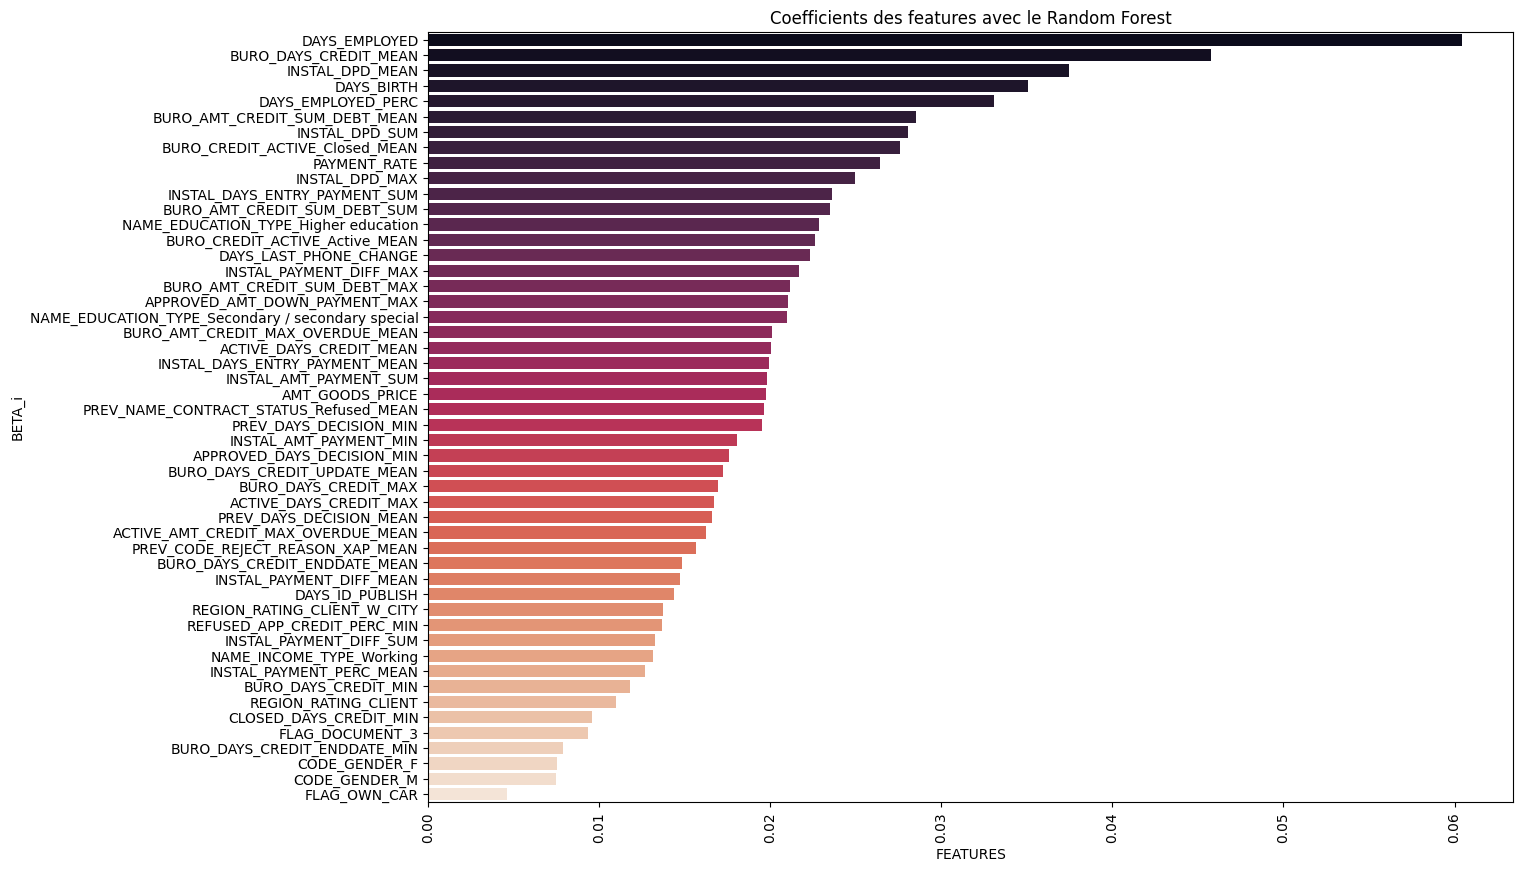

In [64]:
featimps = u810.feature_importance_rf(X_train, be['estimator'], size=52)

In [65]:
estimator = RandomForestClassifier(class_weight='balanced') #


# Parametres Random Forest
params = {
    'estimator__n_estimators' : [10, 1500, 3000],
    'estimator__max_depth' : [10, 50],
    'estimator__min_samples_split' : [10, 200]
}

pipeline = Pipeline(
    [
        # ("feature_engineering", feature_engineering_transformer),
        ("imputer", imputer),
        ("scaler", scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced'))]),
             param_grid={'estimator__max_depth': [10, 50],
                         'estimator__min_samples_split': [10, 200],
                         'estimator__n_estimators': [10, 1500, 3000]},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [66]:
model.best_params_

{'estimator__max_depth': 50,
 'estimator__min_samples_split': 200,
 'estimator__n_estimators': 1500}

In [68]:
def resultification(grid) :
    res = pd.DataFrame(grid.cv_results_)
    keepcols = [col for col in res.columns if "split" not in col]
    res_light = res[keepcols]
    # res_light = res_light.sort_values(by = ['rank_test_r2', 'rank_test_neg_mean_absolute_error'])
    return res, res_light

res, reslight = resultification(model)

In [69]:
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,param_estimator__min_samples_split,param_estimator__n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.365145,0.312898,0.042537,0.000608,10,10,10,"{'estimator__max_depth': 10, 'estimator__min_s...",0.324749,0.319533,...,0.321306,0.002597,9,0.445777,0.447467,0.440668,0.440647,0.442094,0.443331,0.002790
1,86.667464,1.571066,3.729999,0.297467,10,10,1500,"{'estimator__max_depth': 10, 'estimator__min_s...",0.342445,0.329136,...,0.334859,0.007353,5,0.485008,0.485949,0.483266,0.480434,0.481039,0.483139,0.002151
2,166.572972,1.959120,7.292405,0.149194,10,10,3000,"{'estimator__max_depth': 10, 'estimator__min_s...",0.340969,0.331275,...,0.334590,0.007329,6,0.486328,0.483559,0.483947,0.481393,0.481126,0.483271,0.001898
3,1.140081,0.046217,0.039746,0.000286,10,200,10,"{'estimator__max_depth': 10, 'estimator__min_s...",0.332235,0.325192,...,0.327367,0.006758,8,0.377096,0.380425,0.377814,0.374243,0.374725,0.376860,0.002240
4,74.161563,1.633459,3.101379,0.059702,10,200,1500,"{'estimator__max_depth': 10, 'estimator__min_s...",0.344277,0.338754,...,0.339111,0.006525,4,0.392184,0.393290,0.390541,0.387235,0.389027,0.390455,0.002165
5,147.794768,3.102575,6.210485,0.131752,10,200,3000,"{'estimator__max_depth': 10, 'estimator__min_s...",0.344660,0.338502,...,0.339985,0.005537,2,0.390933,0.393670,0.391581,0.387822,0.389275,0.390656,0.001998
6,1.439701,0.024090,0.052995,0.001123,50,10,10,"{'estimator__max_depth': 50, 'estimator__min_s...",0.244025,0.257251,...,0.255207,0.007069,10,0.700075,0.693156,0.696998,0.694263,0.700613,0.697021,0.002992
7,124.614549,1.380530,5.422761,0.093667,50,10,1500,"{'estimator__max_depth': 50, 'estimator__min_s...",0.246214,0.249327,...,0.251824,0.004814,11,0.841496,0.840705,0.843005,0.832254,0.837211,0.838934,0.003844
8,256.261722,3.702065,11.584312,0.592922,50,10,3000,"{'estimator__max_depth': 50, 'estimator__min_s...",0.247965,0.244351,...,0.251520,0.004959,12,0.842245,0.841825,0.842523,0.832559,0.838523,0.839535,0.003774
9,1.218759,0.014365,0.043004,0.000356,50,200,10,"{'estimator__max_depth': 50, 'estimator__min_s...",0.335533,0.325212,...,0.328602,0.007118,7,0.396115,0.392992,0.389417,0.390681,0.393036,0.392448,0.002298


In [70]:
be = model.best_estimator_
be.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=50,
                                        min_samples_split=200,
                                        n_estimators=1500))])

In [71]:
res.to_csv('./model_outputs/GridSearch_RF.csv')

 TRAIN F2 score model :  0.40860700872560923


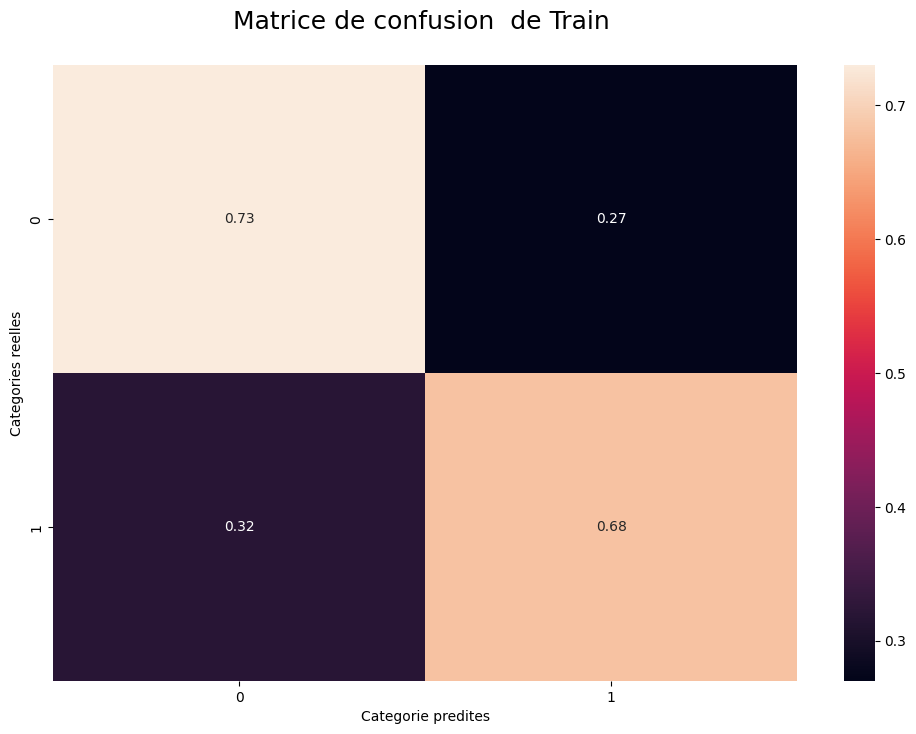

F2 score model 1 :  0.3500424808836024


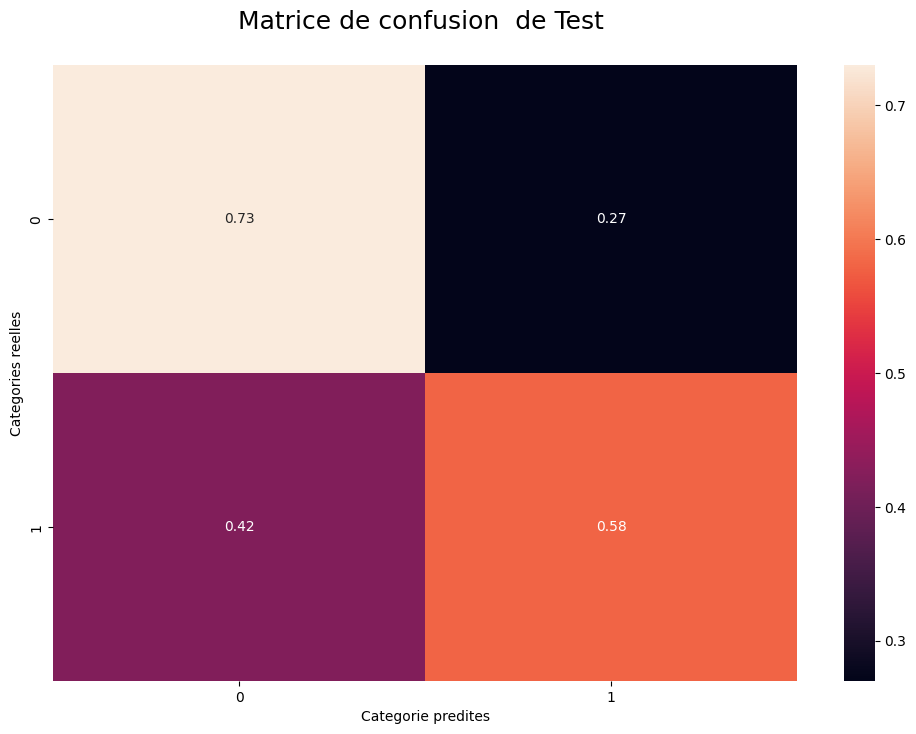

In [72]:
with mlflow.start_run():
    mlflow.log_param("Feature Engineering", "Not embedded in Pipeline")
    mlflow.log_param("imputer", str(be['imputer']))
    mlflow.log_param("scaler", str(be['scaler']))
    mlflow.log_param("estimator", str(be['estimator']))
    mlflow.log_param("over-sampler", str(be['over']))
    mlflow.log_param("under-sampler", str(be['under']))
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

 TRAIN F2 score model :  0.3872536368699148


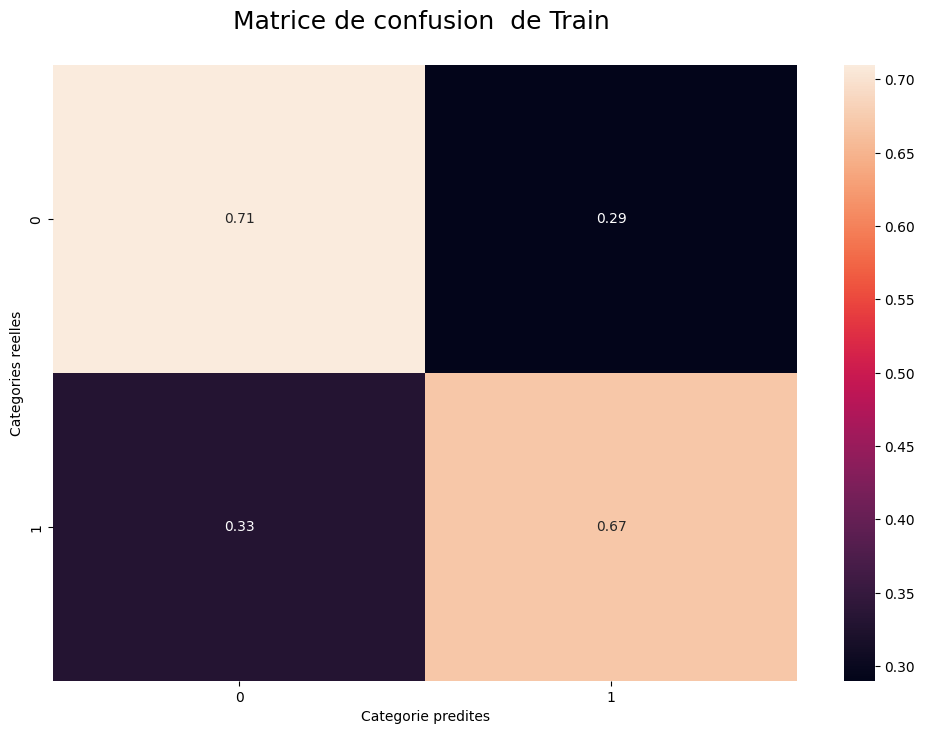

F2 score model 1 :  0.34846999891103125


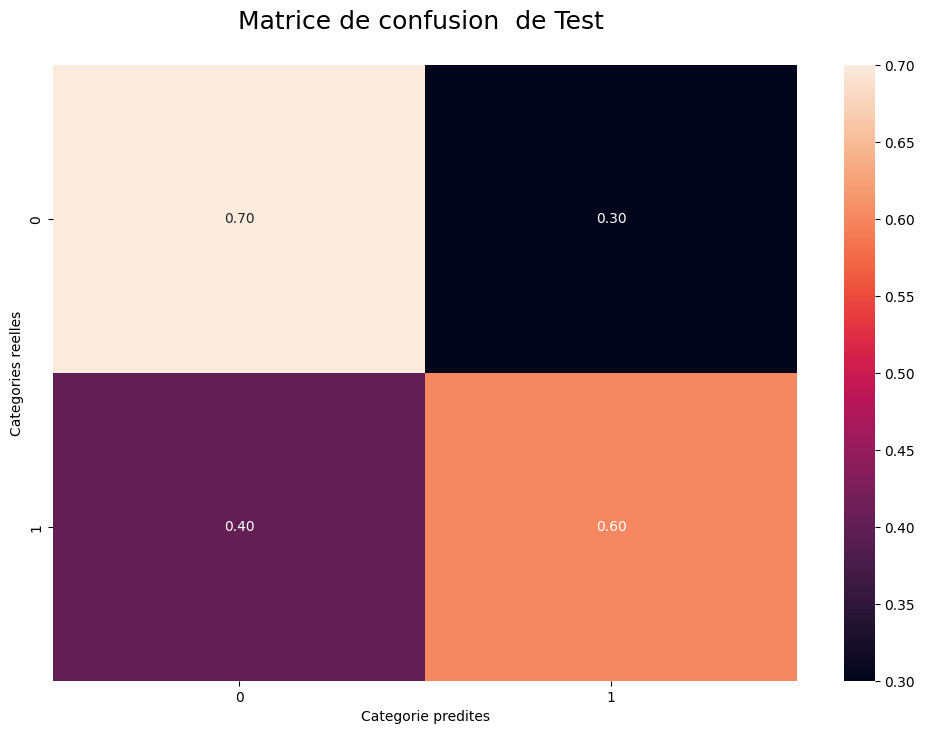

In [73]:
estimator = RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_split=200, n_estimators=3000) #

be = Pipeline(
    [
        # ("feature_engineering", feature_engineering_transformer),
        ("imputer", imputer),
        ("scaler", scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

be.fit(X_train, y_train)

with mlflow.start_run():
    mlflow.log_param("Feature Engineering", "Not embedded in Pipeline")
    mlflow.log_param("imputer", str(be['imputer']))
    mlflow.log_param("scaler", str(be['scaler']))
    mlflow.log_param("estimator", str(be['estimator']))
    mlflow.log_param("over-sampler", str(be['over']))
    mlflow.log_param("under-sampler", str(be['under']))
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

# Test full features

In [74]:
X = df_fe.drop(columns = ['SK_ID_CURR', 'TARGET', 'EXT_SOURCE_3', 'EXT_SOURCE_2'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

X_train : (123035, 599) // X_test : (30759, 599)
y_train : (123035,) // y_test : (30759,)


In [75]:
be.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=200,
                                        n_estimators=3000))])

In [76]:
y_pred = be.predict(X_test)
y_train_pred = be.predict(X_train)

fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
train_auc_score = auc(fpr, tpr)
train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
print("TRAIN F2 score", train_F2_score)
print("TRAIN AUC", train_auc_score)
print("TRAIN Recall", train_rappel)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
test_auc_score = auc(fpr, tpr)
test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
print("TEST F2 score", test_F2_score)
print("TEST AUC", test_auc_score)
print("TEST Recall", test_rappel)


TRAIN F2 score 0.4139930535115088
TRAIN AUC 0.7062083527253415
TRAIN Recall 0.6580886653409755
TEST F2 score 0.35267013232514177
TEST AUC 0.6538307868913856
TEST Recall 0.5587271876462331
